In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef, f1_score, precision_recall_curve, auc, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# Function evaluate MCC and F1 for a given set of true labels and predicted scores
def mcc_f1_curve(y_true, y_scores):
    y_true, y_scores = np.array(y_true), np.array(y_scores)
    thres = np.sort(np.array(y_scores))
    thresholds = np.concatenate([thres, [thres[-1]+1]]) #Adding 1 to the largest score value is the biggest threshold

    y_pred = np.array([(y_scores >= thresholds[i]).astype(int) for i in range(len(thresholds))])
    mcc = np.array([matthews_corrcoef(y_true, y_pred[i,]) for i in range (len(thresholds))])
    mcc_normalized = (mcc + 1) / 2
    f1 = np.array([f1_score(y_true, y_pred[i,]) for i in range(len(thresholds))])
    return f1, mcc_normalized, thresholds


In [3]:
# Functions to calculate for mcc-f1 metric

# Function to calculate Euclidean distance between two points
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Step 1: Find the best threshold (closest point to (1, 1))
def find_best_threshold(f1, mcc, thresholds):
    distances = [euclidean_distance((f1, mcc), (1, 1)) for f1, mcc in zip(f1, mcc)]
    best_index = np.argmin(distances)  # Index of the minimum distance to (1,1)
    best_threshold = thresholds[best_index]
    return best_index, best_threshold

# Step 2: Split into left and right sides based on the best threshold
def split_mcc_f1_1(f1, mcc, thresholds, best_index):
    #based on the best threshold
    left_f1 = f1[:best_index]
    left_mcc = mcc[:best_index]
    right_f1 = f1[best_index:]
    right_mcc = mcc[best_index:]
    return left_f1, left_mcc, right_f1, right_mcc

def split_mcc_f1_2(f1, mcc):
    #based on the mean
    mean_f1 = np.mean(f1)
    left_f1 = f1[f1 <= mean_f1]
    left_mcc = mcc[f1 <= mean_f1]
    right_f1 = f1[f1 > mean_f1]
    right_mcc = mcc[f1 > mean_f1]
    return left_f1, left_mcc, right_f1, right_mcc

def split_mcc_f1_3(f1, mcc):
    #based on the mean or median
    median_f1 = np.median(f1)
    left_f1 = f1[f1 <= median_f1]
    left_mcc = mcc[f1 <= median_f1]
    right_f1 = f1[f1 > median_f1]
    right_mcc = mcc[f1 > median_f1]
    return left_f1, left_mcc, right_f1, right_mcc


# Step 3: Calculate mean distances in subranges
def subrange_mean_distances(f1, mcc, bins=100):
    perfect_point = (1, 1)
    min_mcc = np.min(mcc)
    max_mcc = np.max(mcc)
    # Handle the case where all MCC values are the same
    if min_mcc == max_mcc:
        print("All MCC values are the same. No subrange division needed.")
        distances = [euclidean_distance((f1[j], mcc[j]), perfect_point) for j in range(len(mcc))]
        return [np.mean(distances)]  # Single bin with all points' distances

    subrange_size = (max_mcc - min_mcc) / bins
    #print(f"subrange size is: {subrange_size}, the mcc length is: {len(mcc)}")
    subrange_mean_dist = []
    for i in range(bins+1): #adding 1 more bin at the end to include the max mcc value
        lower_bound = min_mcc + i * subrange_size
        upper_bound = lower_bound + subrange_size
        #print(f"the current subrange: {lower_bound}, {upper_bound}, i = {i}")
        points_in_subrange = [(f1[j], mcc[j]) for j in range(len(mcc)) if lower_bound <= mcc[j] < upper_bound]
        #print(f"there are {len(points_in_subrange)} points in this subrange: {points_in_subrange}")
        
        if len(points_in_subrange) > 0:
            distances = [euclidean_distance(point, perfect_point) for point in points_in_subrange]
            subrange_mean_dist.append(np.mean(distances))
    
    return subrange_mean_dist



# Step 4: Calculate the MCC-F1 metric
def mcc_f1_metric(y_true, y_scores, bins=100, split_choice="original"):
    f1, mcc, thresholds = mcc_f1_curve(y_true, y_scores)
    best_index, best_threshold = find_best_threshold(f1, mcc, thresholds)
    if split_choice == "original":
        left_f1, left_mcc, right_f1, right_mcc = split_mcc_f1_1(f1, mcc, thresholds, best_index)
    elif split_choice == "mean": 
        left_f1, left_mcc, right_f1, right_mcc = split_mcc_f1_2(f1, mcc, thresholds, best_index)
    elif split_choice == "median":
        left_f1, left_mcc, right_f1, right_mcc = split_mcc_f1_3(f1, mcc, thresholds, best_index)
    else: 
        raise ValueError("The split_choice is invalid. Please choose from 'original', 'mean', or 'median'. ")

    if len(left_mcc) == 0 and len(right_mcc) == 0:
        raise ValueError("Warning: both left and right sides are empty!")

    # Case when both left and right sides have data
    elif len(left_mcc) > 0 and len(right_mcc) > 0:
        mean_distances_left = subrange_mean_distances(left_f1, left_mcc, bins)
        mean_distances_right = subrange_mean_distances(right_f1, right_mcc, bins)
        total_mean_dist_left = np.nanmean(mean_distances_left)
        total_mean_dist_right = np.nanmean(mean_distances_right)
        total_mean_distance = (total_mean_dist_left + total_mean_dist_right) / 2

    # If the left side is empty, use only the right side
    elif len(left_mcc) == 0:
        print("Warning: Left side is empty, using right side only")
        mean_distances_right = subrange_mean_distances(right_f1, right_mcc, bins)
        total_mean_distance = np.nanmean(mean_distances_right)

    # If the right side is empty, use only the left side
    elif len(right_mcc) == 0:
        print("Warning: Right side is empty, using left side only")
        mean_distances_left = subrange_mean_distances(left_f1, left_mcc, bins)
        total_mean_distance = np.nanmean(mean_distances_left)
    
    # Calculate the final MCC-F1 metric
    mcc_f1_metric = 1 - (total_mean_distance / np.sqrt(2))
    
    return mcc_f1_metric
    


In [4]:
# Function plot curve for mcc-f1, roc, pr on 1 dataset set with 1 classifier
def plot_mcc_f1_curve(y_true, y_scores, classifier_name, dataset_name, show_threshold_value=True):
    f1, mcc, thresholds = mcc_f1_curve(y_true, y_scores)
    plt.figure(figsize=(6, 6))
    plt.plot(f1, mcc, marker='o', markersize=1, color='darkorange')
    plt.plot([0, 1], [0.5, 0.5], color='navy', lw=2, linestyle='--', label='Random Classifier')
    if show_threshold_value is True:
        for i in range(len(thresholds)):
            plt.text(f1[i], mcc[i], f'{thresholds[i]:.2f}', fontsize=9, verticalalignment='bottom', horizontalalignment='right')
    
    plt.title(f'MCC-F1 Curve for {classifier_name} on {dataset_name}')
    plt.xlabel('F1 Score')
    plt.ylabel('MCC normalized')
    plt.xlim([-0.1, 1.1])  # Add some margin on the x-axis
    plt.ylim([-0.1, 1.1])
    plt.grid(True)
    plt.show()

def plot_roc_curve(y_true, y_scores, classifier_name, dataset_name, show_threshold_value=True):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, marker='o', color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    if show_threshold_value is True:
        for i in range(len(thresholds)):
            plt.text(fpr[i], tpr[i], f'{thresholds[i]:.2f}', fontsize=9, verticalalignment='bottom', horizontalalignment='right')
    
    plt.title(f'ROC Curve for {classifier_name} on {dataset_name}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.xlim([-0.1, 1.1])  # Add some margin on the x-axis
    plt.ylim([-0.1, 1.1])
    plt.grid(True)
    plt.show()


def plot_pr_curve(y_true, y_scores, classifier_name, dataset_name, show_threshold_value=True):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, marker='o', color='darkorange')
    positive_class_ratio = sum(y_true) / len(y_true)
    plt.axhline(y=positive_class_ratio, color='navy', lw=2, linestyle='--', label=f'Random Classifier (Precision = {positive_class_ratio:.2f})')
    if show_threshold_value is True:
        for i in range(len(thresholds)):
            plt.text(recall[i], precision[i], f'{thresholds[i]:.2f}', fontsize=9, verticalalignment='bottom', horizontalalignment='right')
    
    plt.title(f'PR Curve for {classifier_name} on {dataset_name}')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.xlim([-0.1, 1.1])  # Add some margin on the x-axis
    plt.ylim([-0.1, 1.1])
    plt.grid(True)
    plt.show()



In [5]:
# Function plot the left and right side division for different division methods (based on best threshold index, mean f1 value and median f1 value)
def plot_mcc_f1_left_right_divide(y_true, y_scores, show_threshold_value = True):
#####################################Plot for the MCC F1 curve for all threshold values 
    f1, mcc, thresholds = mcc_f1_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(f1, mcc, color='darkorange', marker='o')
    plt.title('MCC-F1 Curve')
    plt.xlabel('F1 Score')
    plt.ylabel('MCC (Unit Normalized)')
    plt.grid(True)
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    if show_threshold_value:
        for i in range(len(thresholds)):
            plt.text(f1[i], mcc[i], f'{thresholds[i]:.2f}', fontsize=8, verticalalignment='bottom', horizontalalignment='right')

    print(f"The true class values are: {y_true}")
    print(f"The predicted score values are: {y_scores}")
    print(f"The ratio between positive class and negative class is: {sum(y_true)} : {len(y_true) - sum(y_true)}")

#####################################Plot for the left and right points division 
    best_index, best_threshold = find_best_threshold(f1, mcc, thresholds)
    left_f1_1, left_mcc_1, right_f1_1, right_mcc_1 = split_mcc_f1_1(f1, mcc, thresholds, best_index)
    left_f1_2, left_mcc_2, right_f1_2, right_mcc_2 = split_mcc_f1_2(f1, mcc)
    left_f1_3, left_mcc_3, right_f1_3, right_mcc_3 = split_mcc_f1_3(f1, mcc)


    # Plot the MCC-F1 curve for left and right sides
    # Create a horizontal 1x3 plot layout
    fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True, sharey=True)

    # Set plot limits
    axs[0].set_xlim([-0.02, 1.02])
    axs[0].set_ylim([-0.02, 1.02])

    # Plot 1: MCC-F1 curve for first split (left_f1_1 and right_f1_1)
    axs[0].plot(f1, mcc, color='darkorange')
    axs[0].scatter(left_f1_1, left_mcc_1, color='blue', label='Left Side 1', marker='o')
    axs[0].scatter(right_f1_1, right_mcc_1, color='red', label='Right Side 1', marker='x')
    axs[0].set_title('MCC-F1 Curve - Split by the best threshold index')
    axs[0].set_xlabel('F1 Score')
    axs[0].set_ylabel('MCC (Unit Normalized)')
    axs[0].grid(True)
    axs[0].legend()

    # Plot 2: MCC-F1 curve for second split (left_f1_2 and right_f1_2)
    axs[1].plot(f1, mcc, color='darkorange')
    axs[1].scatter(left_f1_2, left_mcc_2, color='blue', label='Left Side 2', marker='o')
    axs[1].scatter(right_f1_2, right_mcc_2, color='red', label='Right Side 2', marker='x')
    axs[1].set_title('MCC-F1 Curve - Split by the mean F1 value')
    axs[1].set_xlabel('F1 Score')
    axs[1].grid(True)
    axs[1].legend()

    # Plot 3: MCC-F1 curve for third split (left_f1_3 and right_f1_3)
    axs[2].plot(f1, mcc, color='darkorange')
    axs[2].scatter(left_f1_3, left_mcc_3, color='blue', label='Left Side 3', marker='o')
    axs[2].scatter(right_f1_3, right_mcc_3, color='red', label='Right Side 3', marker='x')
    axs[2].set_title('MCC-F1 Curve - Split by the median F1 value')
    axs[2].set_xlabel('F1 Score')
    axs[2].set_ylabel('MCC (Unit Normalized)')
    axs[2].grid(True)
    axs[2].legend()

    # Show threshold values on all plots if requested
    if show_threshold_value:
        for i in range(len(thresholds)):
            for ax in axs:
                ax.text(f1[i], mcc[i], f'{thresholds[i]:.2f}', fontsize=8, verticalalignment='bottom', horizontalalignment='right')

    plt.tight_layout()
    plt.show()







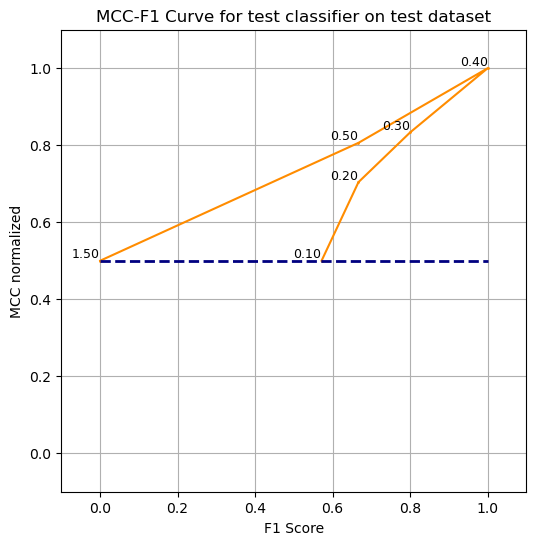

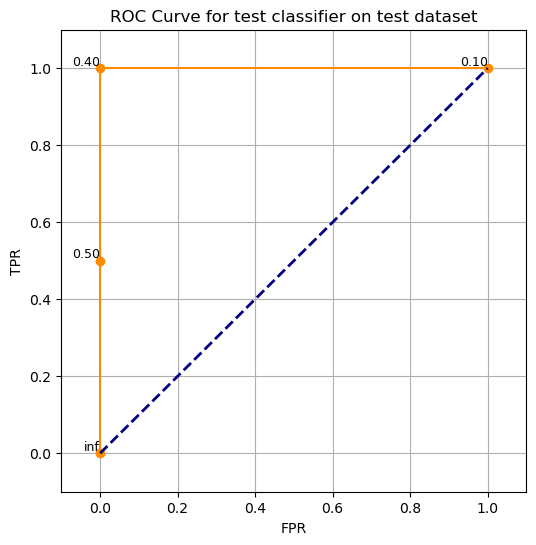

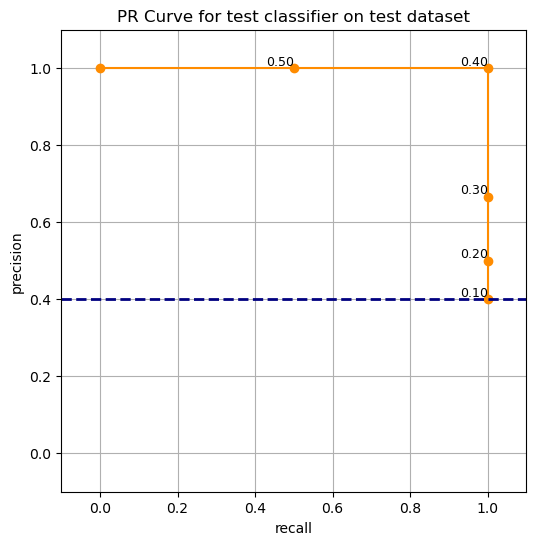

In [161]:
############### Generating Figure 1 in the report - check for metric plot, 
y_true = [0,1,1,0,0]
y_scores = [0.2,0.4,0.5,0.3,0.1]
plot_mcc_f1_curve(y_true, y_scores, "test classifier", "test dataset")
plot_roc_curve(y_true, y_scores, "test classifier", "test dataset")
plot_pr_curve(y_true, y_scores, "test classifier", "test dataset")



In [38]:
# test - check for error in the functions (if any)
y_true = [0,1,1,0,0]
y_scores = [0.2,0.4,0.5,0.3,0.1]
#mcc_f1_metric = mcc_f1_metric(y_true, y_scores)
#print("MCC-F1 Metric:", mcc_f1_metric)

f1, mcc, thresholds = mcc_f1_curve(y_true, y_scores)
best_index, best_threshold = find_best_threshold(f1, mcc, thresholds)
left_f1, left_mcc, right_f1, right_mcc = split_mcc_f1_1(f1, mcc, thresholds, best_index)
print(f"f1: {f1}")
print(f"mcc: {mcc}")
print(f"thresholds: {thresholds}")
print(f"best threshold is {best_threshold}")
print(f"f1_left: {left_f1}")
print(f"mcc_left: {left_mcc}")
print(f"f1_right: {right_f1}")
print(f"mcc_right: {right_mcc}")
mean_left = subrange_mean_distances(left_f1, left_mcc, bins=100)
mean_right = subrange_mean_distances(right_f1, right_mcc, bins=100)

print(f"left mean: {mean_left}")
print(f"right mean: {mean_right}")


f1: [0.57142857 0.66666667 0.8        1.         0.66666667 0.        ]
mcc: [0.5        0.70412415 0.83333333 1.         0.80618622 0.5       ]
thresholds: [0.1 0.2 0.3 0.4 0.5 1.5]
best threshold is 0.4
f1_left: [0.57142857 0.66666667 0.8       ]
mcc_left: [0.5        0.70412415 0.83333333]
f1_right: [1.         0.66666667 0.        ]
mcc_right: [1.         0.80618622 0.5       ]
left mean: [0.6585388898066349, 0.44570576902912784, 0.2603416558635552]
right mean: [1.118033988749895, 0.38558383428667475, 0.0]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


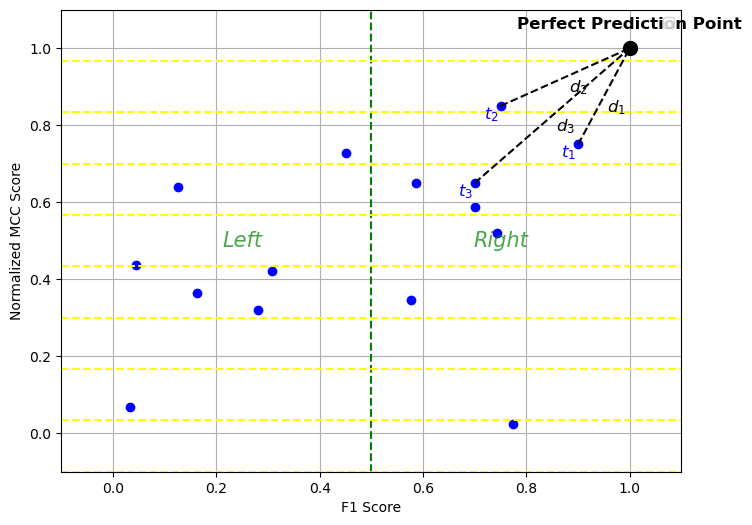

In [14]:
############### Generating Figure 2
fixed_points = np.array([[0.9, 0.75], [0.75, 0.85], [0.70, 0.65]])
random_points = np.column_stack((np.random.uniform(0, 0.8, 12), np.random.uniform(0, 0.8, 12)))
points = np.vstack((fixed_points, random_points))
x = points[:,0]
y = points[:,1]
# plot a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue')
plt.xlabel('F1 Score')
plt.ylabel('Normalized MCC Score')

# Add a vertical dashed line in the middle (green)
plt.axvline(x=0.5, color='green', linestyle='--')

# Add 10 horizontal dashed lines (yellow) dividing the y-axis
y_limits = (-0.1, 1.1)
for i in np.linspace(y_limits[0], y_limits[1], 10):
    plt.axhline(y=i, color='yellow', linestyle='--')

# Add text labels 'Left' and 'Right'
plt.text(0.25, 0.5, 'Left', fontsize=15, color='green', style='italic', alpha=0.7, ha='center', va='center')
plt.text(0.75, 0.5, 'Right', fontsize=15, color='green', style='italic', alpha=0.7, ha='center', va='center')

# Annotate the first 3 points with labels t1, t2, t3
for i, label in enumerate(['$t_1$', '$t_2$', '$t_3$']):
    plt.text(x[i] - 0.033, y[i] - 0.033, label, fontsize=12, color='blue')

# Add the perfect prediction point (1,1) in bold black
plt.scatter(1, 1, color='black', s=100, zorder=5)
plt.text(1, 1.05, 'Perfect Prediction Point', fontsize=12, color='black', weight='bold', ha='center')

# Add black dashed lines connecting the first 3 points to (1,1)
for i, label in enumerate(['$d_1$', '$d_2$', '$d_3$']):
    plt.plot([x[i], 1], [y[i], 1], color='black', linestyle='--')
    # Add label for each dashed line
    plt.text((x[i] + 1.05) / 2, (y[i] + 0.92) / 2, label, fontsize=12, color='black', ha='center')

# Set axis limits
plt.xlim(-0.1, 1.1)
plt.ylim(y_limits)


plt.grid(True)
plt.legend()
plt.show()

The true class values are: [0, 1, 1, 0, 0, 1, 0, 1]
The predicted score values are: [0.2, 0.4, 0.5, 0.3, 0.1, 0.4, 0.4, 0.8]
The ratio between positive class and negative class is: 4 : 4


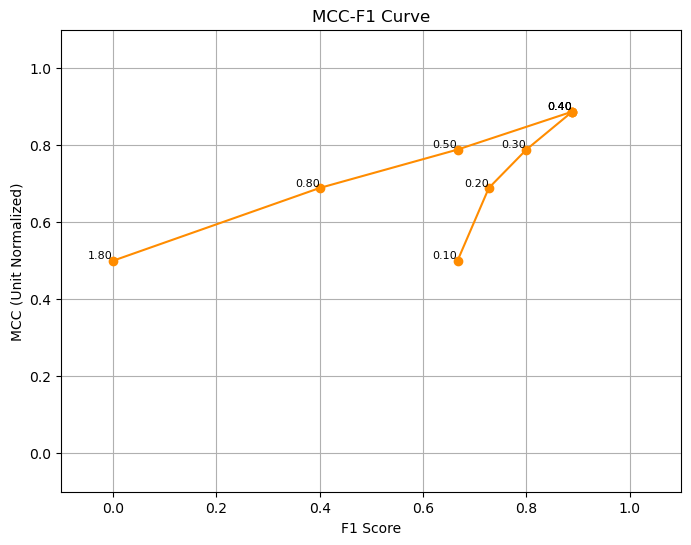

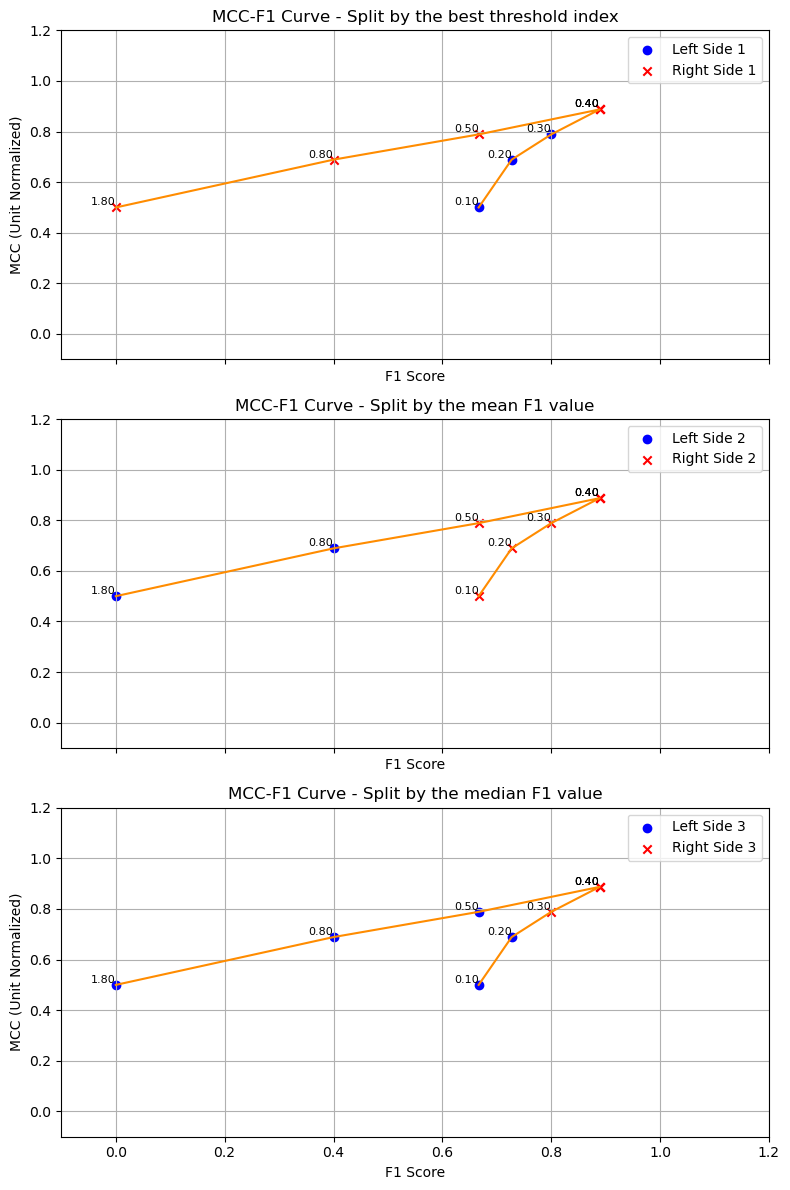

The true class values are: [0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
The predicted score values are: [0.3, 0.25, 0.4, 0.2, 0.45, 0.55, 0.6, 0.5, 0.25, 0.6]
The ratio between positive class and negative class is: 2 : 8


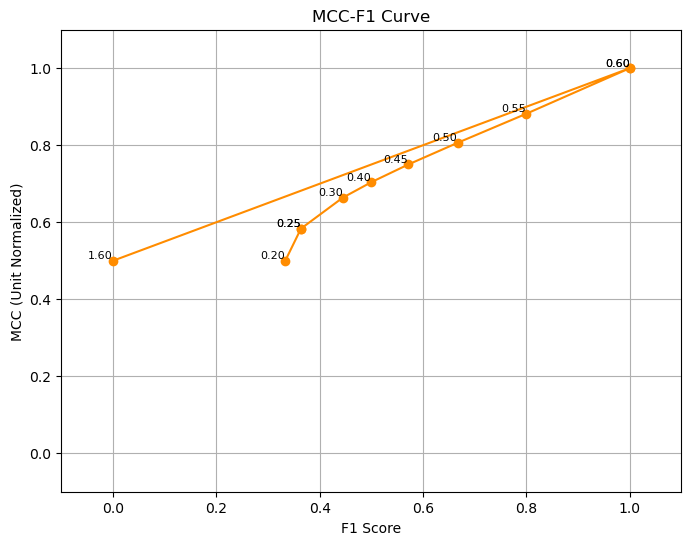

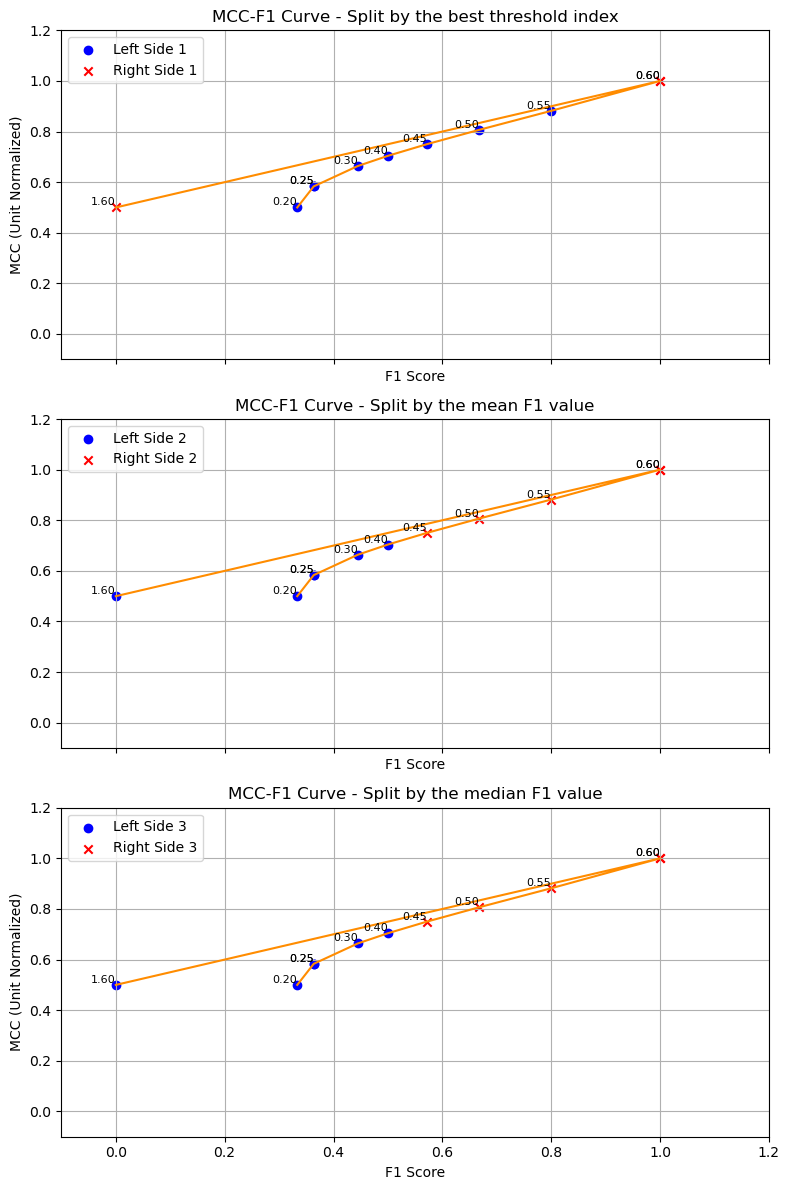

The true class values are: [1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
The predicted score values are: [0.8, 0.8, 0.3, 0.4, 0.6, 0.72, 0.92, 0.78, 0.88, 0.4]
The ratio between positive class and negative class is: 7 : 3


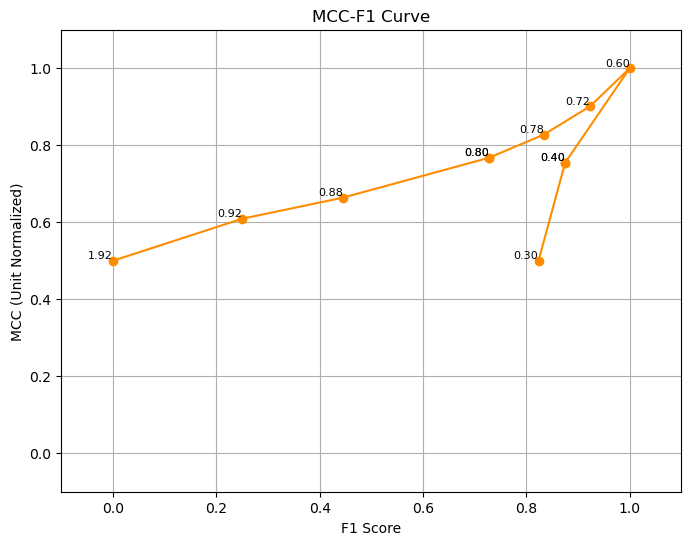

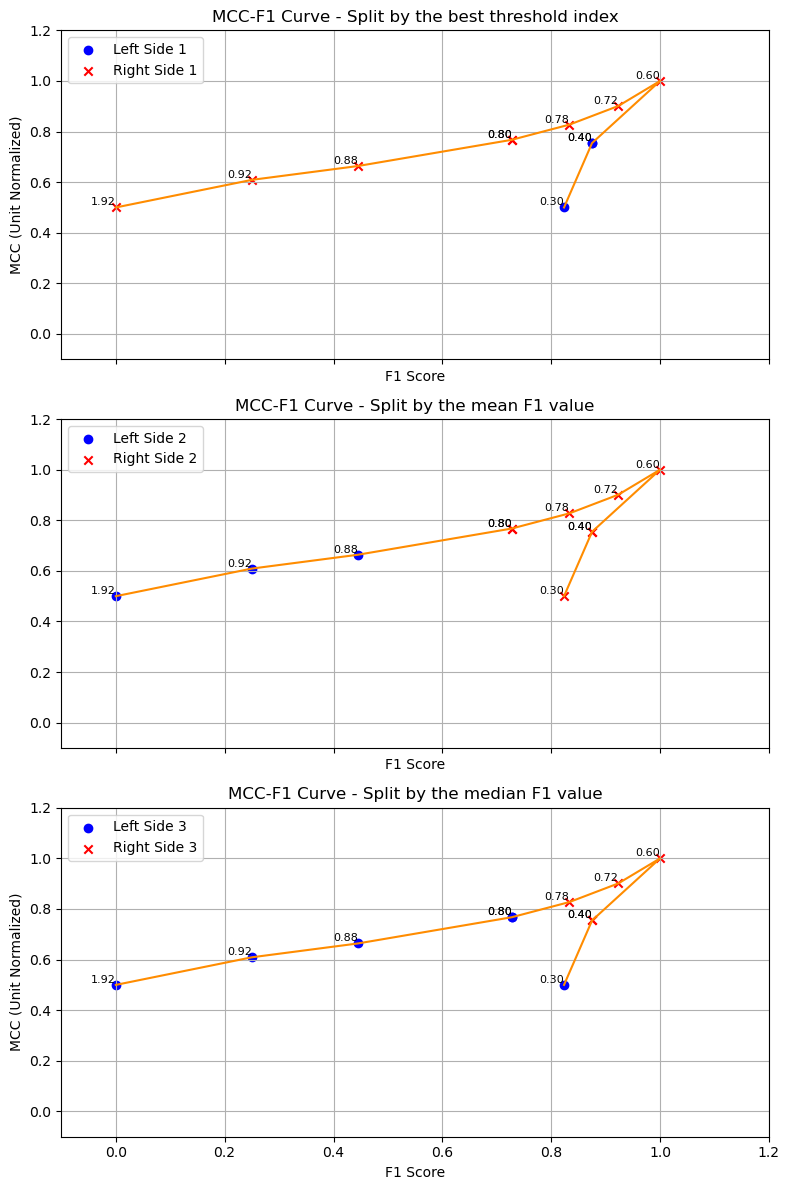

In [86]:
############### Generating Figure 3 - 5 in the report 
# Plot to see different right-left divide for the threshold values. 
y_true = [0,1,1,0,0,1,0,1]
y_scores = [0.2,0.4,0.5,0.3,0.1,0.4,0.4,0.8]
plot_mcc_f1_left_right_divide(y_true,y_scores)

y_true = [0,0,0,0,0,0,1,0,0,1]
y_scores = [0.3, 0.25, 0.4, 0.2, 0.45, 0.55, 0.6, 0.5,0.25, 0.6]
plot_mcc_f1_left_right_divide(y_true,y_scores)

y_true = [1,1,0,0,1,1,1,1,1,0]
y_scores = [0.8,0.8,0.3,0.4,0.6,0.72,0.92,0.78,0.88,0.4]
plot_mcc_f1_left_right_divide(y_true,y_scores)



In [6]:
########## test on X datasets as in the original paper
n_pos = 1000
n_neg = 10000
B_beta_pos = [4,3]
B_beta_neg = [2,3]
A_beta_pos1 = [12,2]
A_beta_pos2 = [3,4]
A_beta_neg = [2,3]
A_pos1pct = 0.3

#################Start simulation
A_pos2pct = 1 - A_pos1pct
A_n_pos1 = int(A_pos1pct*n_pos)
A_n_pos2 = int(A_pos2pct*n_pos)
# y true value 
y_true = np.concatenate([np.ones(n_pos), np.zeros(n_neg)])

# Generate beta distribution scores for classifier A
pos1_scores_A = np.concatenate([np.random.beta(A_beta_pos1[0], A_beta_pos1[1], size=A_n_pos1)])
pos2_scores_A = np.concatenate([np.random.beta(A_beta_pos2[0], A_beta_pos2[1], size=A_n_pos2)])
neg_scores_A = np.random.beta(B_beta_neg[0], B_beta_neg[1], size=n_neg)
y_scores_A = np.concatenate([pos1_scores_A, pos2_scores_A, neg_scores_A])
# Generate beta distribution scores for classifier B
pos_scores_B = np.concatenate([np.random.beta(B_beta_pos[0], B_beta_pos[1], size=n_pos)])
neg_scores_B = np.random.beta(B_beta_neg[0], B_beta_neg[1], size=n_neg)
y_scores_B = np.concatenate([pos_scores_B, neg_scores_B])

#print(f"A_scores: {y_scores_A}")
#print(f"B_scores: {y_scores_B}")
#print(y_true)


#########################calculate the metric scores
mccf1_metric_A = mcc_f1_metric(y_true, y_scores_A)
aucroc_metric_A = roc_auc_score(y_true, y_scores_A)
precision_A, recall_A, thresholds_A = precision_recall_curve(y_true, y_scores_A)
aucpr_metric_A = auc(recall_A, precision_A)

mccf1_metric_B = mcc_f1_metric(y_true, y_scores_B)
aucroc_metric_B = roc_auc_score(y_true, y_scores_B)
precision_B, recall_B, thresholds_B = precision_recall_curve(y_true, y_scores_B)
aucpr_metric_B = auc(recall_B, precision_B)

print(f"the postive vs negative data points: {n_pos} : {n_neg}")
print(f"mcc-f1 metric for classifier A is: {mccf1_metric_A}")
print(f"auc-roc metric for classifier A is: {aucroc_metric_A}")
print(f"auc-pr metric for classifier A is: {aucpr_metric_A}")

print(f"mcc-f1 metric for classifier B is: {mccf1_metric_B}")
print(f"auc-roc metric for classifier B is: {aucroc_metric_B}")
print(f"auc-pr metric for classifier B is: {aucpr_metric_B}")



the postive vs negative data points: 1000 : 10000
mcc-f1 metric for classifier A is: 0.3518573900095099
auc-roc metric for classifier A is: 0.6689881999999999
auc-pr metric for classifier A is: 0.30186707918269007
mcc-f1 metric for classifier B is: 0.3298115545171809
auc-roc metric for classifier B is: 0.7218944999999999
auc-pr metric for classifier B is: 0.18430227265702495


In [7]:
########## test on Y datasets as in the original paper
n_pos = 10000
n_neg = 1000
B_beta_pos = [4,3]
B_beta_neg = [2,3]
A_beta_pos1 = [12,2]
A_beta_pos2 = [3,4]
A_beta_neg = [2,3]
A_pos1pct = 0.3

#################Start simulation
A_pos2pct = 1 - A_pos1pct
A_n_pos1 = int(A_pos1pct*n_pos)
A_n_pos2 = int(A_pos2pct*n_pos)
# y true value 
y_true = np.concatenate([np.ones(n_pos), np.zeros(n_neg)])

# Generate beta distribution scores for classifier A
pos1_scores_A = np.concatenate([np.random.beta(A_beta_pos1[0], A_beta_pos1[1], size=A_n_pos1)])
pos2_scores_A = np.concatenate([np.random.beta(A_beta_pos2[0], A_beta_pos2[1], size=A_n_pos2)])
neg_scores_A = np.random.beta(B_beta_neg[0], B_beta_neg[1], size=n_neg)
y_scores_A = np.concatenate([pos1_scores_A, pos2_scores_A, neg_scores_A])
# Generate beta distribution scores for classifier B
pos_scores_B = np.concatenate([np.random.beta(B_beta_pos[0], B_beta_pos[1], size=n_pos)])
neg_scores_B = np.random.beta(B_beta_neg[0], B_beta_neg[1], size=n_neg)
y_scores_B = np.concatenate([pos_scores_B, neg_scores_B])

#print(f"A_scores: {y_scores_A}")
#print(f"B_scores: {y_scores_B}")
#print(y_true)


#########################calculate the metric scores
mccf1_metric_A = mcc_f1_metric(y_true, y_scores_A)
aucroc_metric_A = roc_auc_score(y_true, y_scores_A)
precision_A, recall_A, thresholds_A = precision_recall_curve(y_true, y_scores_A)
aucpr_metric_A = auc(recall_A, precision_A)

mccf1_metric_B = mcc_f1_metric(y_true, y_scores_B)
aucroc_metric_B = roc_auc_score(y_true, y_scores_B)
precision_B, recall_B, thresholds_B = precision_recall_curve(y_true, y_scores_B)
aucpr_metric_B = auc(recall_B, precision_B)

print(f"the postive vs negative data points: {n_pos} : {n_neg}")
print(f"mcc-f1 metric for classifier A is: {mccf1_metric_A}")
print(f"auc-roc metric for classifier A is: {aucroc_metric_A}")
print(f"auc-pr metric for classifier A is: {aucpr_metric_A}")

print(f"mcc-f1 metric for classifier B is: {mccf1_metric_B}")
print(f"auc-roc metric for classifier B is: {aucroc_metric_B}")
print(f"auc-pr metric for classifier B is: {aucpr_metric_B}")



the postive vs negative data points: 10000 : 1000
mcc-f1 metric for classifier A is: 0.5139354435332231
auc-roc metric for classifier A is: 0.6827141999999999
auc-pr metric for classifier A is: 0.9567492343145981
mcc-f1 metric for classifier B is: 0.6042207702213175
auc-roc metric for classifier B is: 0.7290525
auc-pr metric for classifier B is: 0.9571722750558058


In [8]:
########## test on Z datasets as in the original paper
n_pos = 10000
n_neg = 10000
B_beta_pos = [4,3]
B_beta_neg = [2,3]
A_beta_pos1 = [12,2]
A_beta_pos2 = [3,4]
A_beta_neg = [2,3]
A_pos1pct = 0.3

#################Start simulation
A_pos2pct = 1 - A_pos1pct
A_n_pos1 = int(A_pos1pct*n_pos)
A_n_pos2 = int(A_pos2pct*n_pos)
# y true value 
y_true = np.concatenate([np.ones(n_pos), np.zeros(n_neg)])

# Generate beta distribution scores for classifier A
pos1_scores_A = np.concatenate([np.random.beta(A_beta_pos1[0], A_beta_pos1[1], size=A_n_pos1)])
pos2_scores_A = np.concatenate([np.random.beta(A_beta_pos2[0], A_beta_pos2[1], size=A_n_pos2)])
neg_scores_A = np.random.beta(B_beta_neg[0], B_beta_neg[1], size=n_neg)
y_scores_A = np.concatenate([pos1_scores_A, pos2_scores_A, neg_scores_A])
# Generate beta distribution scores for classifier B
pos_scores_B = np.concatenate([np.random.beta(B_beta_pos[0], B_beta_pos[1], size=n_pos)])
neg_scores_B = np.random.beta(B_beta_neg[0], B_beta_neg[1], size=n_neg)
y_scores_B = np.concatenate([pos_scores_B, neg_scores_B])

#print(f"A_scores: {y_scores_A}")
#print(f"B_scores: {y_scores_B}")
#print(y_true)


#########################calculate the metric scores
mccf1_metric_A = mcc_f1_metric(y_true, y_scores_A)
aucroc_metric_A = roc_auc_score(y_true, y_scores_A)
precision_A, recall_A, thresholds_A = precision_recall_curve(y_true, y_scores_A)
aucpr_metric_A = auc(recall_A, precision_A)

mccf1_metric_B = mcc_f1_metric(y_true, y_scores_B)
aucroc_metric_B = roc_auc_score(y_true, y_scores_B)
precision_B, recall_B, thresholds_B = precision_recall_curve(y_true, y_scores_B)
aucpr_metric_B = auc(recall_B, precision_B)

print(f"the postive vs negative data points: {n_pos} : {n_neg}")
print(f"mcc-f1 metric for classifier A is: {mccf1_metric_A}")
print(f"auc-roc metric for classifier A is: {aucroc_metric_A}")
print(f"auc-pr metric for classifier A is: {aucpr_metric_A}")

print(f"mcc-f1 metric for classifier B is: {mccf1_metric_B}")
print(f"auc-roc metric for classifier B is: {aucroc_metric_B}")
print(f"auc-pr metric for classifier B is: {aucpr_metric_B}")



the postive vs negative data points: 10000 : 10000
mcc-f1 metric for classifier A is: 0.4895621252113096
auc-roc metric for classifier A is: 0.67658589
auc-pr metric for classifier A is: 0.7172708312750589
mcc-f1 metric for classifier B is: 0.5258456338359392
auc-roc metric for classifier B is: 0.7422878299999999
auc-pr metric for classifier B is: 0.7110579174503168


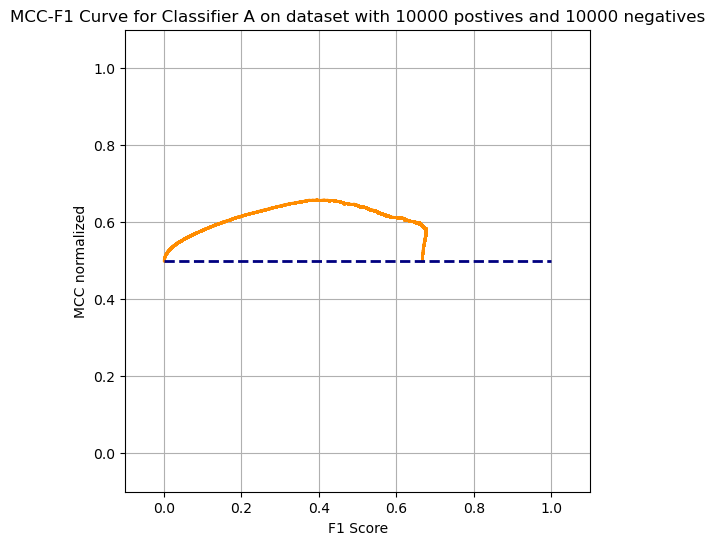

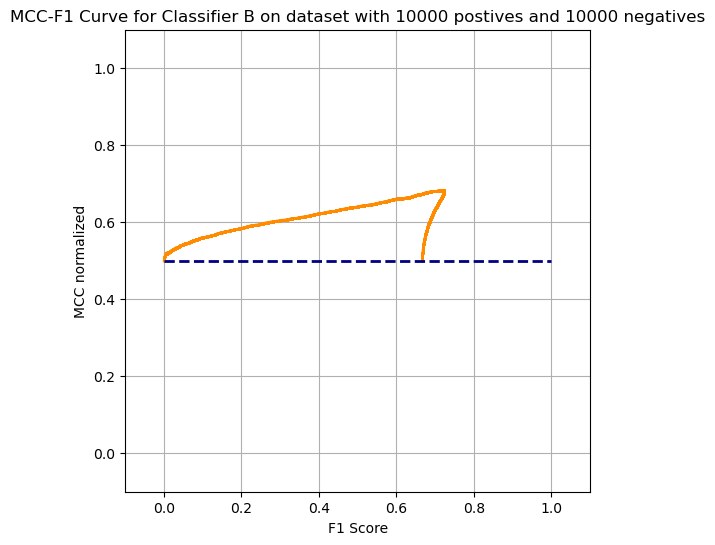

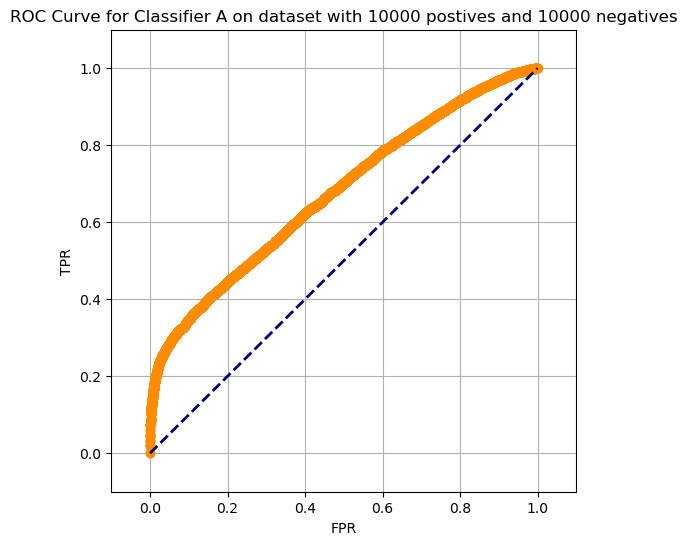

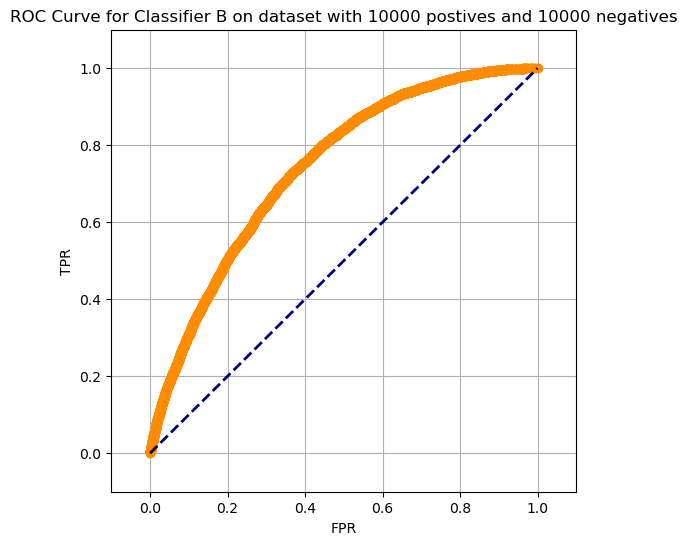

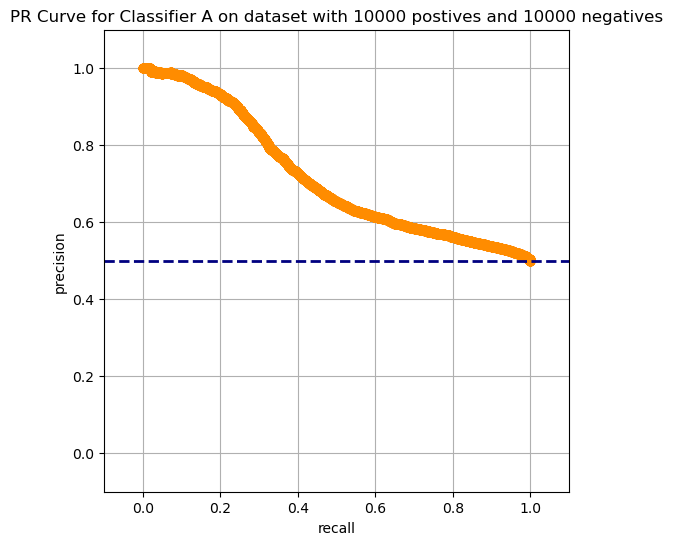

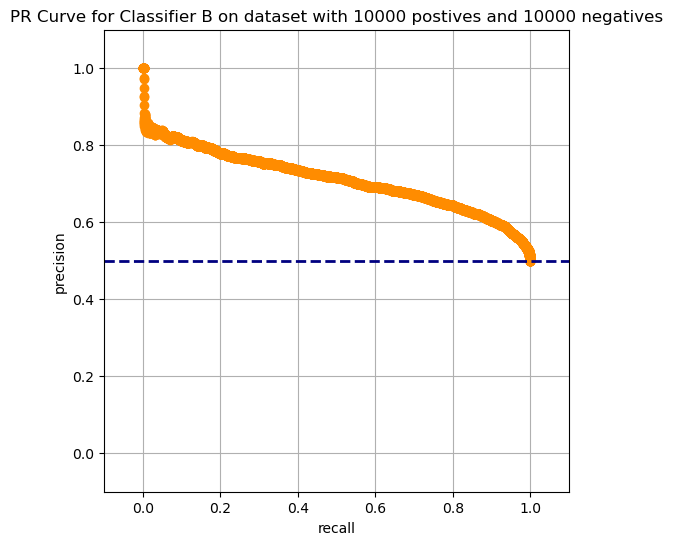

In [9]:
########## test for plots as in the original paper
#########################plot the curves
plot_mcc_f1_curve(y_true, y_scores_A, "Classifier A", f"dataset with {n_pos} postives and {n_neg} negatives", show_threshold_value=False)
plot_mcc_f1_curve(y_true, y_scores_B,  "Classifier B", f"dataset with {n_pos} postives and {n_neg} negatives", show_threshold_value=False)

plot_roc_curve(y_true,y_scores_A, "Classifier A", f"dataset with {n_pos} postives and {n_neg} negatives", show_threshold_value=False)
plot_roc_curve(y_true,y_scores_B, "Classifier B", f"dataset with {n_pos} postives and {n_neg} negatives", show_threshold_value=False)

plot_pr_curve(y_true, y_scores_A, "Classifier A", f"dataset with {n_pos} postives and {n_neg} negatives", show_threshold_value=False)
plot_pr_curve(y_true, y_scores_B, "Classifier B", f"dataset with {n_pos} postives and {n_neg} negatives", show_threshold_value=False)






In [93]:
# Function to generate different datasets
# Example: n_base_ratio = 20, total_length = 1000, means that we generate 19 datasets
#          starting from 100 positive + 1900 negative, 200 pos + 1800 neg, ..., 1900 pos + 100 neg
def generate_datasets(n_base_ratio, total_length):
    datasets = []
    
    for i in range(1, n_base_ratio):
        # Calculate the proportion of positive and negative samples
        n_positives = int((i / n_base_ratio) * total_length)
        n_negatives = total_length - n_positives
        
        # Create the dataset with the desired proportion of positive and negative samples
        data = np.concatenate([np.ones(n_positives), np.zeros(n_negatives)])
        
        datasets.append(data)
    
    return datasets


In [94]:
############### Set-up for experiment 1
# Generate 50 datasets, each with a total length of 10000
# Create the beta distributions 
datasets = generate_datasets(50,10000)
B_beta_pos = [4,3]
B_beta_neg = [2,3]
A_beta_pos1 = [12,2]
A_beta_pos2 = [3,4]
A_beta_neg = [2,3]
A_pos1pct = 0.3



In [95]:
################ Start simulation for experiment 1
all_datasets_posRatio = []
x_labels = []
all_mccf1_metric_A = []
all_aucroc_metric_A = []
all_aucpr_metric_A = []

all_mccf1_metric_B = []
all_aucroc_metric_B = []
all_aucpr_metric_B = []

for i, dataset in enumerate(datasets):
    y_true = dataset
    n_pos = int(np.sum(dataset))
    n_neg = int(len(dataset) - n_pos)

    pos_ratio = n_pos/(len(dataset))
    all_datasets_posRatio.append(pos_ratio)
    x_labels.append(f"Dataset {i + 1}: {int(n_pos)} pos, {int(n_neg)} neg")


    A_n_pos1 = int(A_pos1pct*n_pos)
    A_n_pos2 = int(n_pos - A_n_pos1)
    #A_n_pos1 = int(A_pos1pct*n_pos)
    #A_n_pos2 = n_pos - A_beta_pos1
    print(type(A_n_pos1))

    # Generate beta distribution scores for classifier A
    pos1_scores_A = np.concatenate([np.random.beta(A_beta_pos1[0], A_beta_pos1[1], size = A_n_pos1)])
    pos2_scores_A = np.concatenate([np.random.beta(A_beta_pos2[0], A_beta_pos2[1], size = A_n_pos2)])
    neg_scores_A = np.random.beta(B_beta_neg[0], B_beta_neg[1], size=n_neg)
    y_scores_A = np.concatenate([pos1_scores_A, pos2_scores_A, neg_scores_A])
    # Generate beta distribution scores for classifier B
    pos_scores_B = np.concatenate([np.random.beta(B_beta_pos[0], B_beta_pos[1], size=n_pos)])
    neg_scores_B = np.random.beta(B_beta_neg[0], B_beta_neg[1], size=n_neg)
    y_scores_B = np.concatenate([pos_scores_B, neg_scores_B])

    ################# calculate the metric scores
    mccf1_metric_A = mcc_f1_metric(y_true, y_scores_A)
    aucroc_metric_A = roc_auc_score(y_true, y_scores_A)
    precision_A, recall_A, thresholds_A = precision_recall_curve(y_true, y_scores_A)
    aucpr_metric_A = auc(recall_A, precision_A)
    all_mccf1_metric_A.append(mccf1_metric_A)
    all_aucroc_metric_A.append(aucroc_metric_A)
    all_aucpr_metric_A.append(aucpr_metric_A)

    mccf1_metric_B = mcc_f1_metric(y_true, y_scores_B)
    aucroc_metric_B = roc_auc_score(y_true, y_scores_B)
    precision_B, recall_B, thresholds_B = precision_recall_curve(y_true, y_scores_B)
    aucpr_metric_B = auc(recall_B, precision_B)
    all_mccf1_metric_B.append(mccf1_metric_B)
    all_aucroc_metric_B.append(aucroc_metric_B)
    all_aucpr_metric_B.append(aucpr_metric_B)

    print(f"Dataset {i + 1}: {int(n_pos)} positives, {int(n_neg)} negatives. ")
    print(f"mcc-f1 metric for classifier A is: {mccf1_metric_A}, auc-roc metric for classifier A is: {aucroc_metric_A}, auc-pr metric for classifier A is: {aucpr_metric_A}")
    print(f"mcc-f1 metric for classifier B is: {mccf1_metric_B}, auc-roc metric for classifier B is: {aucroc_metric_B}, auc-pr metric for classifier B is: {aucpr_metric_B}")

    


<class 'int'>
Dataset 1: 200 positives, 9800 negatives. 
mcc-f1 metric for classifier A is: 0.2887083852679866, auc-roc metric for classifier A is: 0.6503061224489796, auc-pr metric for classifier A is: 0.08827243763817423
mcc-f1 metric for classifier B is: 0.2537576635593699, auc-roc metric for classifier B is: 0.7311576530612245, auc-pr metric for classifier B is: 0.04350829134457407
<class 'int'>
Dataset 2: 400 positives, 9600 negatives. 
mcc-f1 metric for classifier A is: 0.3120657411796337, auc-roc metric for classifier A is: 0.6789080729166665, auc-pr metric for classifier A is: 0.18569311616940232
mcc-f1 metric for classifier B is: 0.28169836466719356, auc-roc metric for classifier B is: 0.73301875, auc-pr metric for classifier B is: 0.0934322828239524
<class 'int'>
Dataset 3: 600 positives, 9400 negatives. 
mcc-f1 metric for classifier A is: 0.33569400383599146, auc-roc metric for classifier A is: 0.666167730496454, auc-pr metric for classifier A is: 0.23890962613994948
mcc-f1 

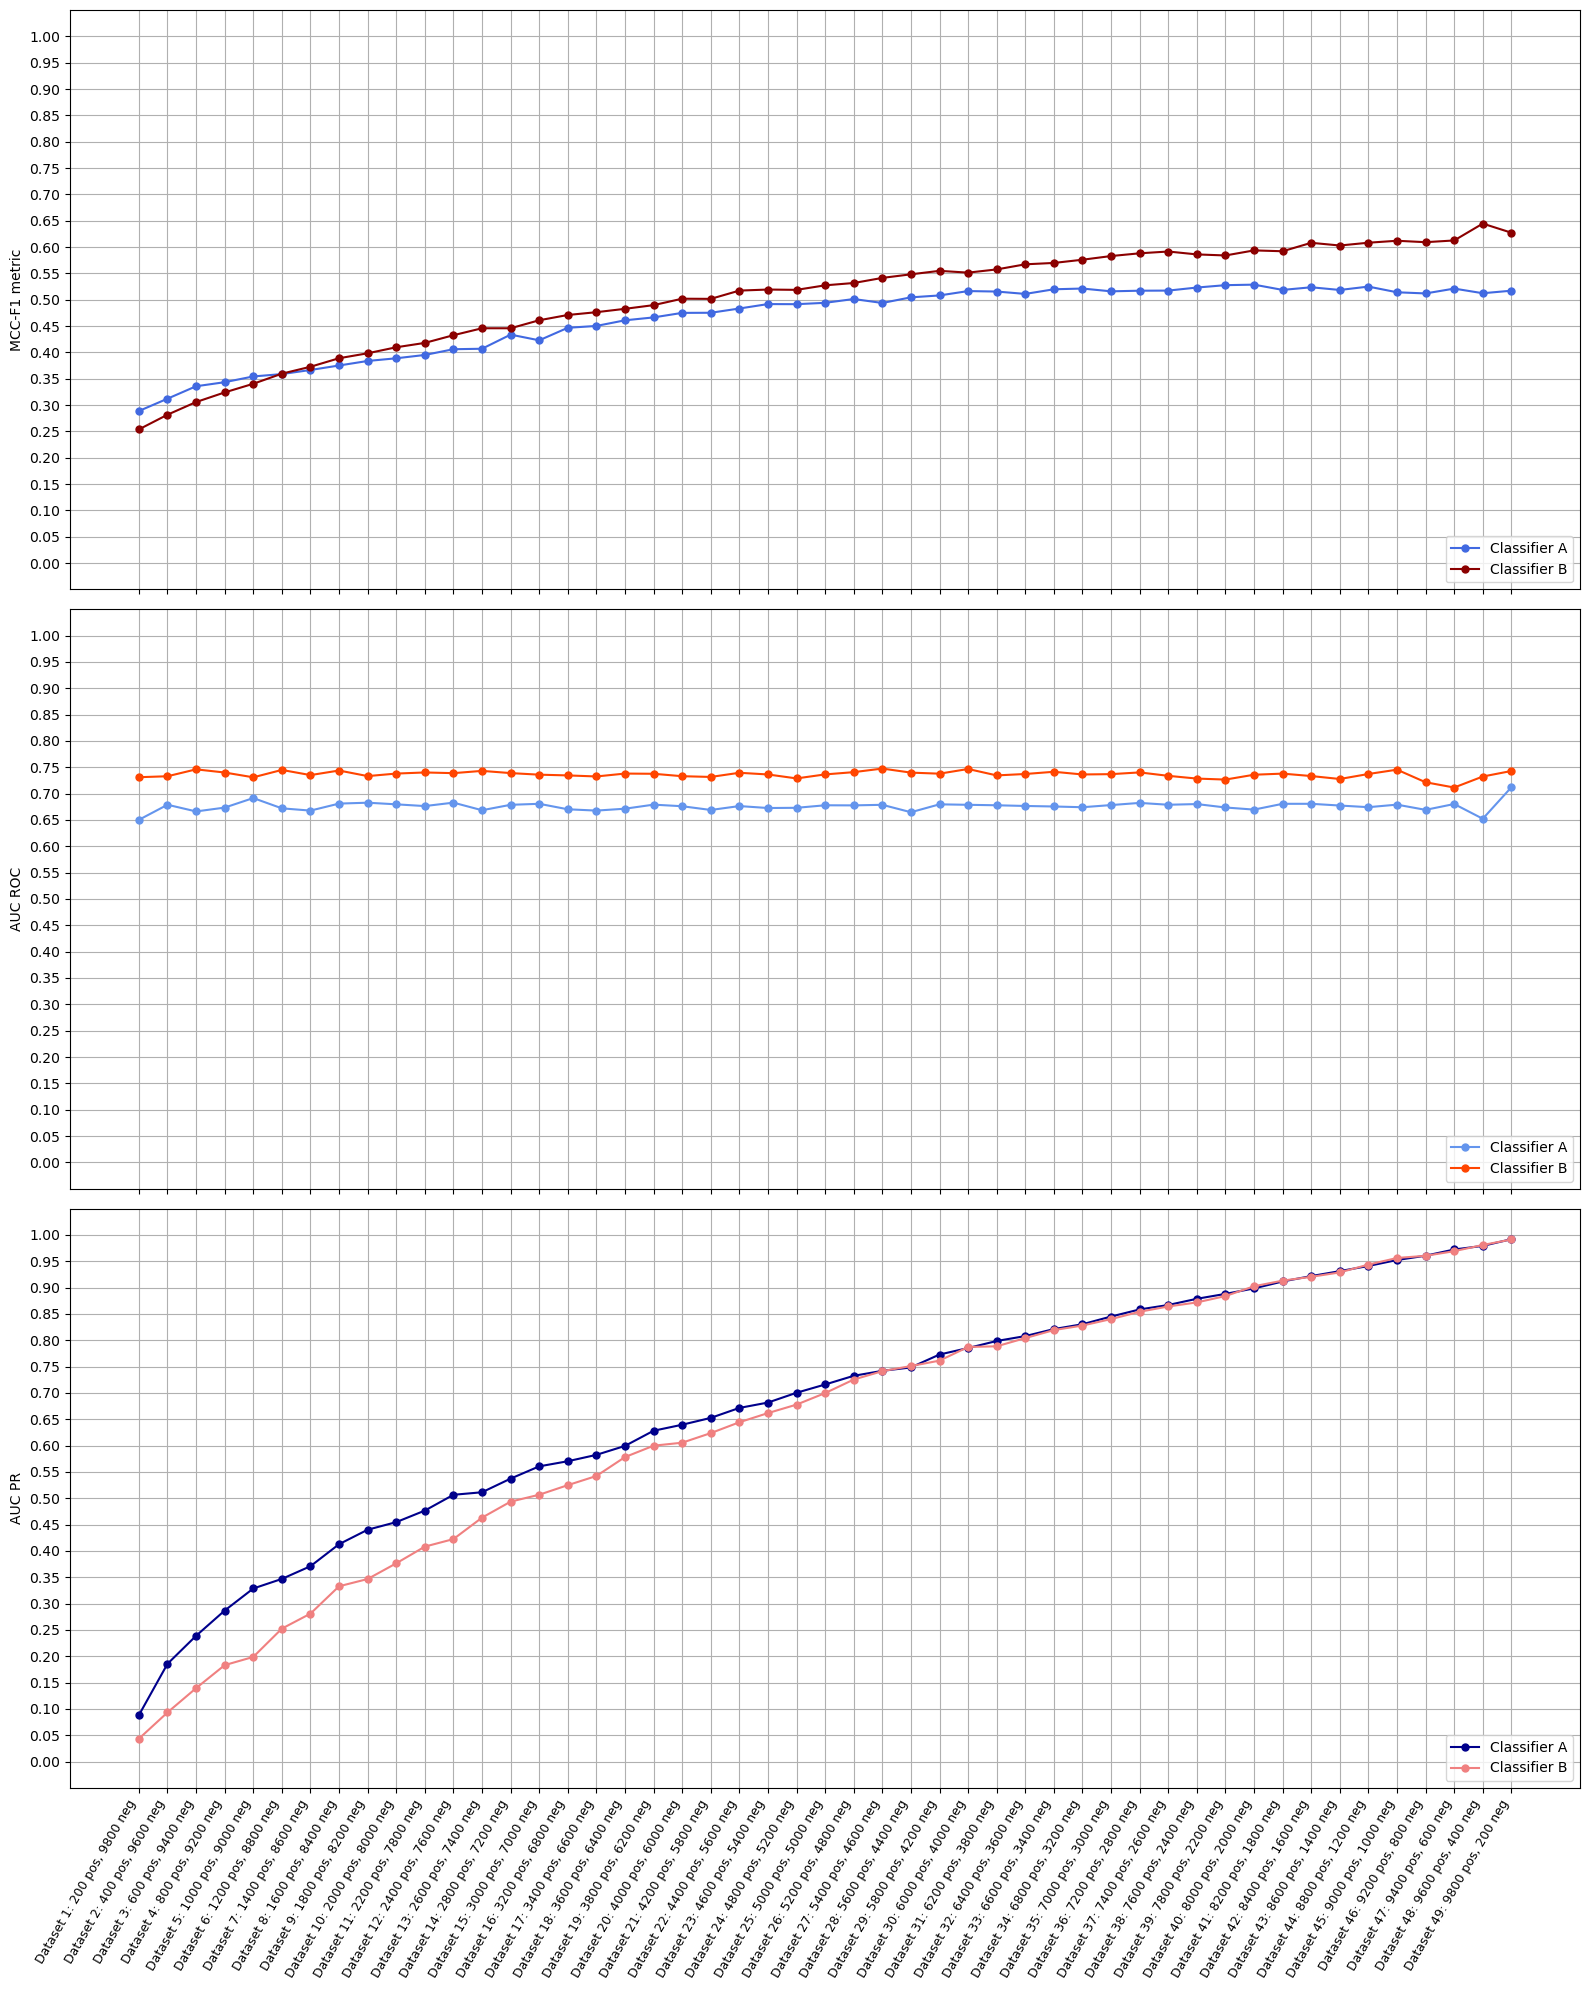

In [105]:
################# Experiment 1 result and figure: Plot for classifiers performances vs different datasets

#we round the values to 4 decimal places
all_mccf1_metric_A = np.round(np.array(all_mccf1_metric_A), 4)
all_aucroc_metric_A = np.round(np.array(all_aucroc_metric_A), 4)
all_aucpr_metric_A = np.round(np.array(all_aucpr_metric_A), 4)

all_mccf1_metric_B = np.round(np.array(all_mccf1_metric_B), 4)
all_aucroc_metric_B = np.round(np.array(all_aucroc_metric_B), 4)
all_aucpr_metric_B = np.round(np.array(all_aucpr_metric_B), 4)

##########################################################################################
#####plot mccf1 metric, aucroc, aucpr for classifier A and B
fig1, axs1 = plt.subplots(3, 1, sharex=True, figsize=(16, 20))

# Remove vertical space between Axes
fig1.subplots_adjust(hspace=0.3)
#fig1.suptitle("Metrics Comparison for Classifier A and B", fontsize=12)
#fig1.subplots_adjust(top=1.85)

t = [i for i in range(len(x_labels))]

# Plot each graph, and manually set the y tick values
# Plot for mcc f1
axs1[0].plot(t, all_mccf1_metric_A, marker='o', markersize=5, color='royalblue', label='Classifier A')
axs1[0].plot(t, all_mccf1_metric_B, marker='o', markersize=5, color='darkred', label='Classifier B')
axs1[0].set_yticks(np.arange(0, 1.01, 0.05))
axs1[0].set_ylim(-0.05, 1.05)
axs1[0].set_ylabel("MCC-F1 metric")
axs1[0].legend(loc='lower right')
axs1[0].grid(True)

# Plot for AUC ROC
axs1[1].plot(t, all_aucroc_metric_A, marker='o', markersize=5, color='cornflowerblue', label='Classifier A')
axs1[1].plot(t, all_aucroc_metric_B, marker='o', markersize=5, color='orangered', label='Classifier B')
axs1[1].set_yticks(np.arange(0, 1.01, 0.05))
axs1[1].set_ylim(-0.05, 1.05)
axs1[1].set_ylabel("AUC ROC")
axs1[1].legend(loc='lower right')
axs1[1].grid(True)

# Plot for AUC PR 
axs1[2].plot(t, all_aucpr_metric_A, marker='o', markersize=5, color='darkblue', label='Classifier A')
axs1[2].plot(t, all_aucpr_metric_B, marker='o', markersize=5, color='lightcoral', label='Classifier B')
axs1[2].set_yticks(np.arange(0, 1.01, 0.05))
axs1[2].set_ylim(-0.05, 1.05)
axs1[2].set_ylabel("AUC PR")
axs1[2].legend(loc='lower right')
axs1[2].grid(True)

# Set the x-ticks and x-tick labels only for the bottom subplot (since sharex=True)
axs1[2].set_xticks(t)
axs1[2].set_xticklabels(x_labels)

# Rotate the x-axis labels
plt.xticks(rotation=60, ha='right', fontsize=9)

# Display the plot
plt.tight_layout()   # Adjust layout to prevent clipping of tick labels
plt.show()



In [160]:
################# Experiment 1 table: Calculate the rounded score difference of classifier A and B to see which one wins, corresponding to different datasets
classifier_A_wins = np.round(np.array(all_mccf1_metric_A) - np.array(all_mccf1_metric_B), 4)
mccf1_win_score = []
which_classifier_win = []

for i in range(len(t)):
    if classifier_A_wins[i] > 0:
        which_classifier_win.append("Classifier A")
        mccf1_win_score.append(classifier_A_wins[i])
        #print(f"For {x_labels[i]}, classifier A wins for score: {classifier_A_wins[i]}")
    elif classifier_A_wins[i] < 0:
        which_classifier_win.append("Classifier B")
        mccf1_win_score.append(-classifier_A_wins[i])
        #print(f"For {x_labels[i]}, classifier B wins for score: {-classifier_A_wins[i]}")
    else:
        which_classifier_win.append("Tie")
        mccf1_win_score.append(classifier_A_wins[i])
        #print(f"For {x_labels[i]}, classifier A and B performs the same: {classifier_A_wins[i]}")

    #print(f"mcc-f1 metric for classifier A is: {all_mccf1_metric_A[i]}, auc-roc metric for classifier A is: {all_aucroc_metric_A[i]}, auc-pr metric for classifier A is: {all_aucpr_metric_A[i]}")
    #print(f"mcc-f1 metric for classifier B is: {all_mccf1_metric_B[i]}, auc-roc metric for classifier B is: {all_aucroc_metric_B[i]}, auc-pr metric for classifier B is: {all_aucpr_metric_B[i]}")


section = len(t)//3
neg_skewed = np.array(which_classifier_win[0:section])
balanced = np.array(which_classifier_win[section:-section])
pos_skewed = np.array(which_classifier_win[-section:])

neg_skewed_B_count = np.count_nonzero(neg_skewed == "Classifier B")
neg_skewed_A_count = np.count_nonzero(neg_skewed == "Classifier A")
balanced_B_count = np.count_nonzero(balanced == "Classifier B")
balanced_A_count = np.count_nonzero(balanced == "Classifier A")
pos_skewed_B_count = np.count_nonzero(pos_skewed == "Classifier B")
pos_skewed_A_count = np.count_nonzero(pos_skewed == "Classifier A")

neg_skewed_A_wins_mean = np.mean(classifier_A_wins[0:section])
balanced_A_wins_mean = np.mean(classifier_A_wins[section:-section])
pos_skewed_A_wins_mean = np.mean(classifier_A_wins[-section:])

total_A_count = which_classifier_win.count("Classifier A")
total_B_count = which_classifier_win.count("Classifier B")
total_A_wins_mean = np.mean(classifier_A_wins)

neg_skewed_datasets = str(t[0]+1) + " to " + str(t[section])
balanced_datasets = str(t[section]+1) + " to " + str(t[-section])
pos_datasets = str(t[-section]+1) + " to " + str(t[-1]+1)
total_datasets = str(t[0]+1) + " to " + str(t[-1]+1)


######                        Datasets          Classifier A wins      Classifier B wins       average score on A - B   
#Negative Skewed datasets  
#Balanced datasets
#Positive Skewed datasets  

df = pd.DataFrame({
    "Datasets": [neg_skewed_datasets, balanced_datasets, pos_datasets, total_datasets],
    "Classifier A wins # times": [neg_skewed_A_count, balanced_A_count, pos_skewed_A_count, total_A_count],
    "Classifier B wins # times": [neg_skewed_B_count, balanced_B_count, pos_skewed_B_count, total_B_count],
    "Average for A - B": [neg_skewed_A_wins_mean, balanced_A_wins_mean, pos_skewed_A_wins_mean, total_A_wins_mean]
}, index=["Negative Skewed datasets ", "Balanced datasets", "Positive Skewed datasets ", "Total Datasets"])  # Set row labels

# Function to apply conditional formatting
def highlight_cells(row):
    if row['Classifier A wins # times'] > row['Classifier B wins # times']:
        return ['', 'background-color: lightblue', '','']  # Highlight Column 2
    elif row['Classifier B wins # times'] > row['Classifier A wins # times']:
        return ['', '', 'background-color: lightblue','']  # Highlight Column 3
    else:
        return ['', '', '','']  # No highlight

# Apply the function to style the DataFrame
styled_df = df.style.apply(highlight_cells, axis=1, subset=['Datasets', 'Classifier A wins # times', 'Classifier B wins # times', 'Average for A - B'])

# Display the styled DataFrame (for Jupyter or notebooks, call styled_df to render it)
styled_df


,Datasets,Classifier A wins # times,Classifier B wins # times,Average for A - B
Negative Skewed datasets,1 to 16,5,11,-0.005656
Balanced datasets,17 to 33,0,17,-0.035182
Positive Skewed datasets,34 to 49,0,16,-0.081594
Total Datasets,1 to 49,5,44,-0.040696


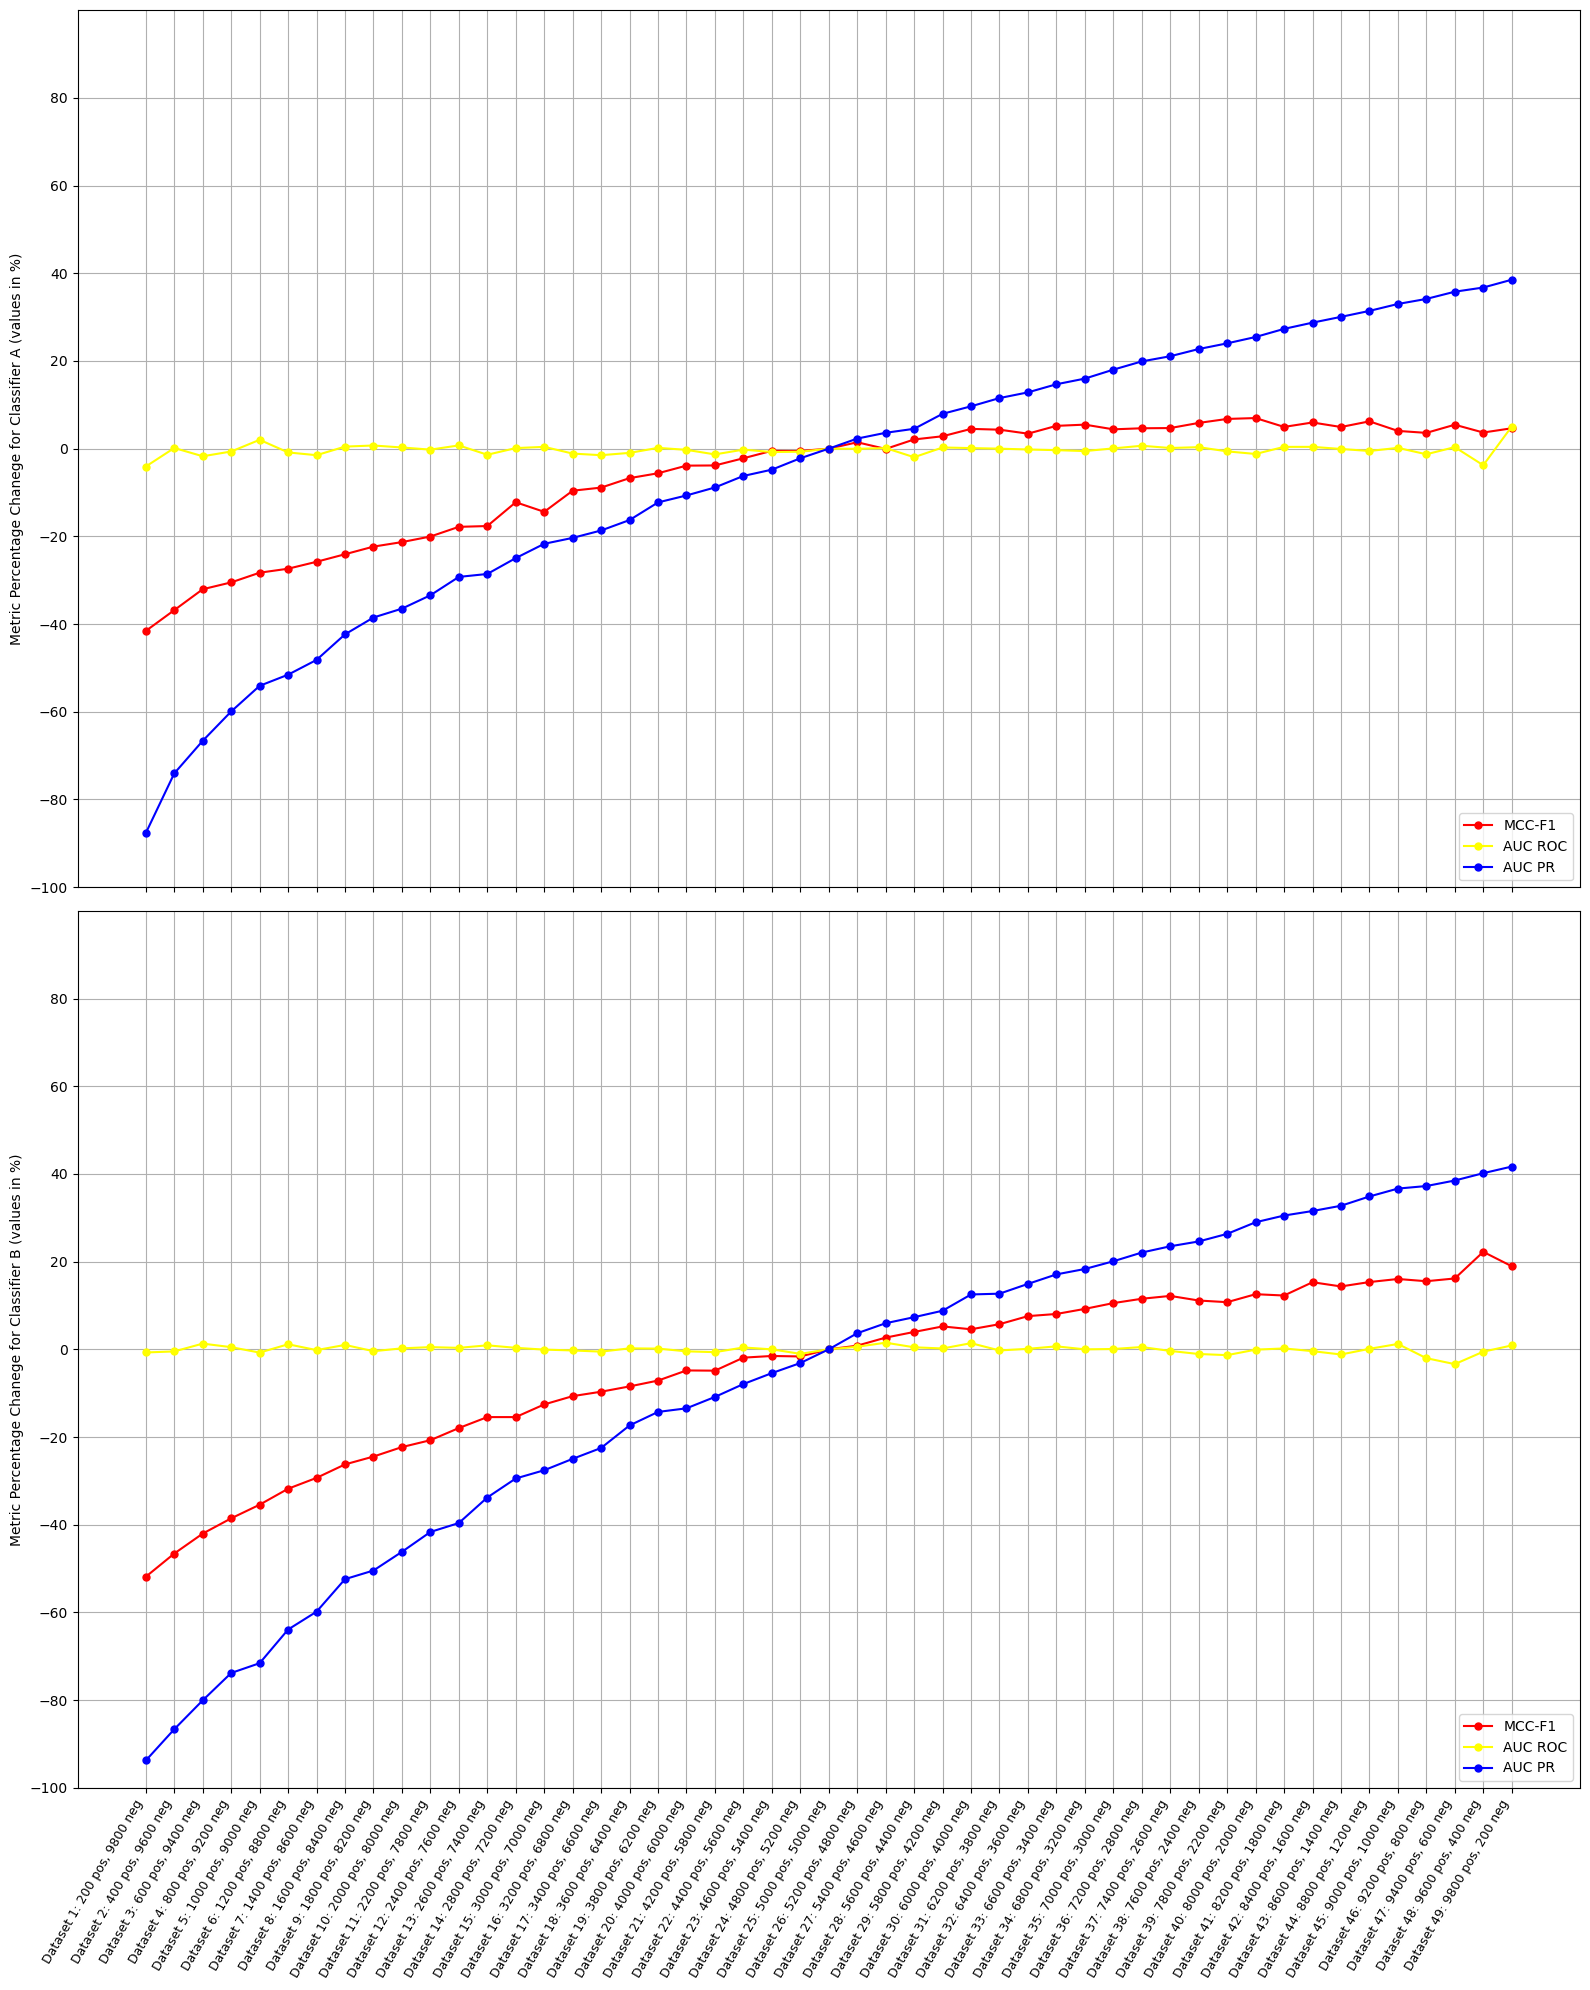

In [162]:
################ Experiment 2: Plot for the Relative Sensitivity Analysis

# Function that calculates the percentage change in a metric
def metric_pct_change(metric, balance_index=None):
    if balance_index is None:
        balance_index = (len(metric)-1)//2
    metric_change = [100 * (metric[i] - metric[balance_index]) / metric[balance_index] for i in range(len(metric))]
    return metric_change



#Plot for classifier performance percentage change comparing to balanced dataset

# we round the change in percentage values to 2 decimal places
mccf1_pct_change_A = np.round(np.array(metric_pct_change(all_mccf1_metric_A)), 2)
aucroc_pct_change_A = np.round(np.array(metric_pct_change(all_aucroc_metric_A)), 2)
aucpr_pct_change_A = np.round(np.array(metric_pct_change(all_aucpr_metric_A)), 2)

mccf1_pct_change_B = np.round(np.array(metric_pct_change(all_mccf1_metric_B)), 2)
aucroc_pct_change_B = np.round(np.array(metric_pct_change(all_aucroc_metric_B)), 2)
aucpr_pct_change_B = np.round(np.array(metric_pct_change(all_aucpr_metric_B)), 2)


##########################################################################################
#####plot mccf1 metric, aucroc, aucpr for classifier A and B
fig2, axs2 = plt.subplots(2, 1, sharex=True, figsize=(16, 20))

# Remove vertical space between Axes
fig1.subplots_adjust(hspace=0.3)
fig1.suptitle("Performance Metrics Percentage Change for Classifier A", fontsize=16)

#t = [i for i in range(len(x_labels))]  ##we already have this from previous block of code

# Plot each graph, and manually set the y tick values
# Plot for classifier A
axs2[0].plot(t, mccf1_pct_change_A, marker='o', markersize=5, color='red', label='MCC-F1')
axs2[0].plot(t, aucroc_pct_change_A, marker='o', markersize=5, color='yellow', label='AUC ROC')
axs2[0].plot(t, aucpr_pct_change_A, marker='o', markersize=5, color='blue', label='AUC PR')
axs2[0].set_yticks(np.arange(-100, 100, 20))
axs2[0].set_ylim(-100.05, 100.05)
axs2[0].set_ylabel("Metric Percentage Chanege for Classifier A (values in %)")
axs2[0].legend(loc='lower right')
axs2[0].grid(True)

# Plot for classifier B
axs2[1].plot(t, mccf1_pct_change_B, marker='o', markersize=5, color='red', label='MCC-F1')
axs2[1].plot(t, aucroc_pct_change_B, marker='o', markersize=5, color='yellow', label='AUC ROC')
axs2[1].plot(t, aucpr_pct_change_B, marker='o', markersize=5, color='blue', label='AUC PR')
axs2[1].set_yticks(np.arange(-100, 100, 20))
axs2[1].set_ylim(-100.05, 100.05)
axs2[1].set_ylabel("Metric Percentage Chanege for Classifier B (values in %)")
axs2[1].legend(loc='lower right')
axs2[1].grid(True)


# Set the x-ticks and x-tick labels only for the bottom subplot (since sharex=True)
axs2[1].set_xticks(t)
axs2[1].set_xticklabels(x_labels)

# Rotate the x-axis labels
plt.xticks(rotation=60, ha='right', fontsize=9)

# Display the plot
plt.tight_layout()   # Adjust layout to prevent clipping of tick labels
plt.show()

    



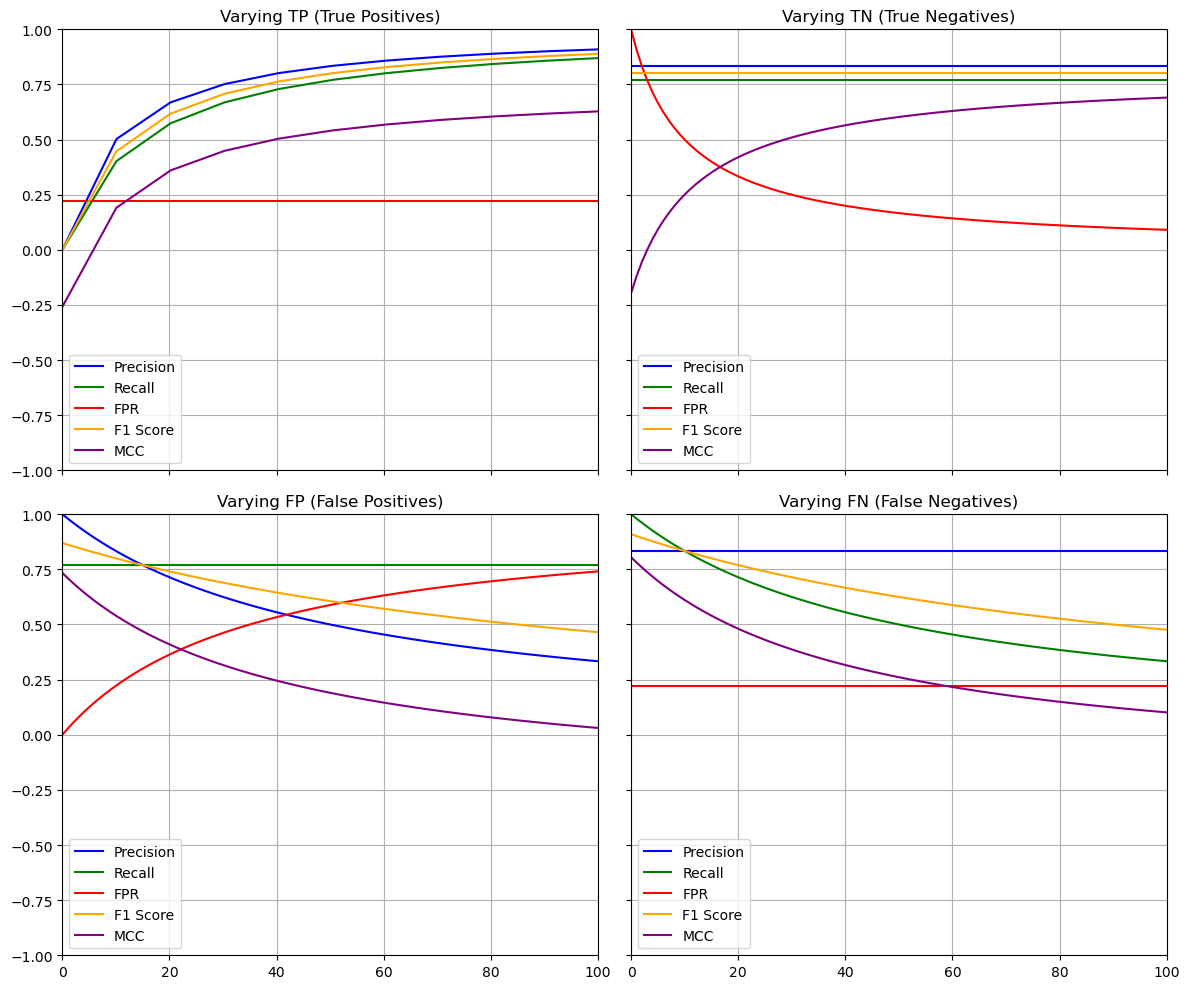

In [100]:
############### Experiment 3: Plot the results varying TP, FP, TN, FN
# In this experiment, we want to see how each metrics change according to changes in TP, FP, TN, FN
def calculate_metrics(tp, fp, tn, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) > 0 else 1
    mcc = numerator / denominator
    return precision, recall, fpr, f1_score, mcc

# Initial fixed values for TP, FP, TN, FN, 
# To avoid them being the same value for Precision, Recall and F1, we set different fixed numbers
tp_fixed = 50
fp_fixed = 10
tn_fixed = 35
fn_fixed = 15

# Arrays to store metrics
precision_vals1, recall_vals1, fpr_vals1, f1_vals1, mcc_vals1 = [], [], [], [], []

# Vary TP, keeping others constant
tp_values = np.linspace(0, 1000, 100)
for tp in tp_values:
    precision, recall, fpr, f1, mcc = calculate_metrics(tp, fp_fixed, tn_fixed, fn_fixed)
    precision_vals1.append(precision)
    recall_vals1.append(recall)
    fpr_vals1.append(fpr)
    f1_vals1.append(f1)
    mcc_vals1.append(mcc)

# Vary FP, keeping others constant
precision_vals2, recall_vals2, fpr_vals2, f1_vals2, mcc_vals2 = [], [], [], [], []
fp_values = np.linspace(0, 100, 100)
for fp in fp_values:
    precision, recall, fpr, f1, mcc = calculate_metrics(tp_fixed, fp, tn_fixed, fn_fixed)
    precision_vals2.append(precision)
    recall_vals2.append(recall)
    fpr_vals2.append(fpr)
    f1_vals2.append(f1)
    mcc_vals2.append(mcc)



# Vary TN, keeping others constant
precision_vals3, recall_vals3, fpr_vals3, f1_vals3, mcc_vals3 = [], [], [], [], []
tn_values = np.linspace(0, 100, 100)
for tn in tn_values:
    precision, recall, fpr, f1, mcc = calculate_metrics(tp_fixed, fp_fixed, tn, fn_fixed)
    precision_vals3.append(precision)
    recall_vals3.append(recall)
    fpr_vals3.append(fpr)
    f1_vals3.append(f1)
    mcc_vals3.append(mcc)

# Vary FN, keeping others constant
precision_vals4, recall_vals4, fpr_vals4, f1_vals4, mcc_vals4 = [], [], [], [], []
fn_values = np.linspace(0, 100, 100)
for fn in fn_values:
    precision, recall, fpr, f1, mcc = calculate_metrics(tp_fixed, fp_fixed, tn_fixed, fn)
    precision_vals4.append(precision)
    recall_vals4.append(recall)
    fpr_vals4.append(fpr)
    f1_vals4.append(f1)
    mcc_vals4.append(mcc)

############################### Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Setting y-axis range to (-1, 1)
plt.ylim(-1, 1)

# Plot 1: Varying TP
axs[0, 0].plot(tp_values, precision_vals1, label="Precision", color="blue")
axs[0, 0].plot(tp_values, recall_vals1, label="Recall", color="green")
axs[0, 0].plot(tp_values, fpr_vals1, label="FPR", color="red")
axs[0, 0].plot(tp_values, f1_vals1, label="F1 Score", color="orange")
axs[0, 0].plot(tp_values, mcc_vals1, label="MCC", color="purple")
axs[0, 0].set_title("Varying TP (True Positives)")
axs[0, 0].grid(True)
axs[0, 0].legend()

# Plot 2: Varying FP
axs[1, 0].plot(fp_values, precision_vals2, label="Precision", color="blue")
axs[1, 0].plot(fp_values, recall_vals2, label="Recall", color="green")
axs[1, 0].plot(fp_values, fpr_vals2, label="FPR", color="red")
axs[1, 0].plot(fp_values, f1_vals2, label="F1 Score", color="orange")
axs[1, 0].plot(fp_values, mcc_vals2, label="MCC", color="purple")
axs[1, 0].set_title("Varying FP (False Positives)")
axs[1, 0].grid(True)
axs[1, 0].legend()

# Plot 3: Varying TN
axs[0, 1].plot(tn_values, precision_vals3, label="Precision", color="blue")
axs[0, 1].plot(tn_values, recall_vals3, label="Recall", color="green")
axs[0, 1].plot(tn_values, fpr_vals3, label="FPR", color="red")
axs[0, 1].plot(tn_values, f1_vals3, label="F1 Score", color="orange")
axs[0, 1].plot(tn_values, mcc_vals3, label="MCC", color="purple")
axs[0, 1].set_title("Varying TN (True Negatives)")
axs[0, 1].grid(True)
axs[0, 1].legend()

# Plot 4: Varying FN
axs[1, 1].plot(fn_values, precision_vals4, label="Precision", color="blue")
axs[1, 1].plot(fn_values, recall_vals4, label="Recall", color="green")
axs[1, 1].plot(fn_values, fpr_vals4, label="FPR", color="red")
axs[1, 1].plot(fn_values, f1_vals4, label="F1 Score", color="orange")
axs[1, 1].plot(fn_values, mcc_vals4, label="MCC", color="purple")
axs[1, 1].set_title("Varying FN (False Negatives)")
axs[1, 1].grid(True)
axs[1, 1].legend()

# Set common labels and limits
plt.xlim(0, 100)
plt.ylim(-1, 1)

plt.tight_layout()
plt.show()


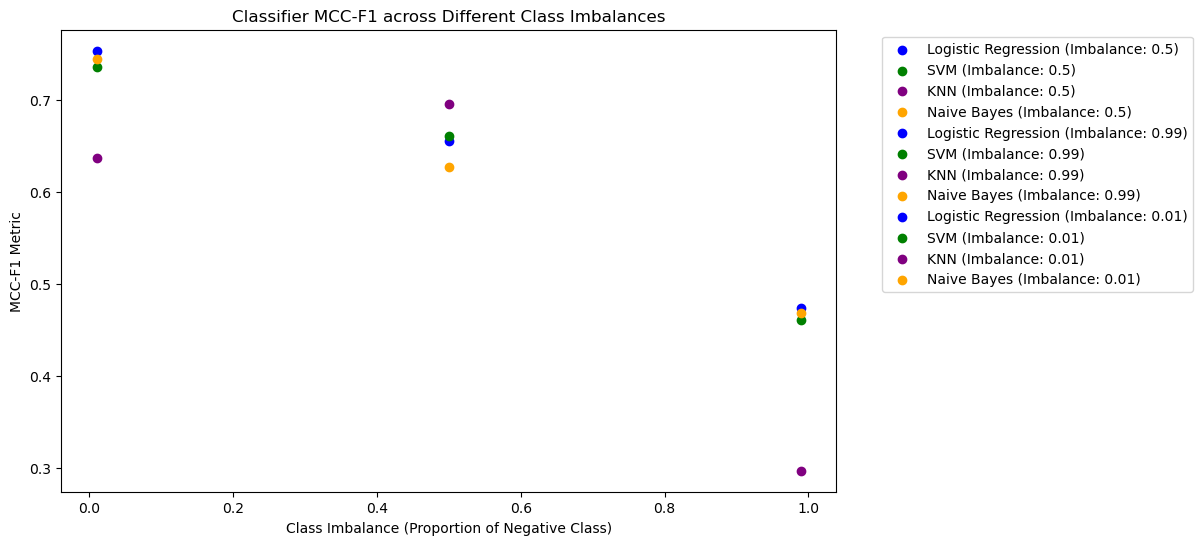

In [17]:
############### Experiment 4: Plot optimal classifier across datasets  

# Define classifiers to test
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Define colors for each classifier
colors = {
    'Logistic Regression': 'blue',
    'SVM': 'green',
    'KNN': 'purple',
    'Naive Bayes': 'orange'
}

# Generate datasets with different class imbalances
imbalances = [0.5, 0.99, 0.01]  # Balanced, Negatively Imbalanced, Positively Imbalanced
results = []

for imbalance in imbalances:
    # Generate dataset with the given imbalance
    X, y = make_classification(n_samples=10000, n_features=20, n_classes=2, weights=[imbalance, 1 - imbalance])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Evaluate classifiers using MCC-F1 metric
    metrics = {'Classifier': [], 'MCC-F1': []}
    
    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else clf.decision_function(X_test)
        
        # Calculate MCC-F1 score using the provided function
        mcc_f1_score = mcc_f1_metric(y_test, y_prob)
        
        metrics['Classifier'].append(clf_name)
        metrics['MCC-F1'].append(mcc_f1_score)
    
    results.append((imbalance, metrics))

# Plot MCC-F1 results for different classifiers
plt.figure(figsize=(10, 6))
for imbalance, metrics in results:
    for clf_name, clf_metric in zip(metrics['Classifier'], metrics['MCC-F1']):
        plt.scatter(imbalance, clf_metric, label=f"{clf_name} (Imbalance: {imbalance})", color=colors[clf_name])

plt.xlabel("Class Imbalance (Proportion of Negative Class)")
plt.ylabel("MCC-F1 Metric")
plt.title("Classifier MCC-F1 across Different Class Imbalances")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

